## Part 2: FNC-1 LSTM 

Github dataset: https://github.com/FakeNewsChallenge/fnc-1

Learning resources: <br>
1. Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/ <br>
2. The Unreasonable Effectiveness of Recurrent Neural Networks http://karpathy.github.io/2015/05/21/rnn-effectiveness/

Reference projects: <br>
1. Glove+LSTM 95.08% Acc https://www.kaggle.com/code/abhinavkrjha/glove-lstm-95-08-acc <br>
2. Stance-based model https://www.kaggle.com/code/sadoukhamzatarik/stance-based-model <br>
3. Preprocessing for DL https://towardsdatascience.com/nlp-learning-series-part-1-text-preprocessing-methods-for-deep-learning-20085601684b <br>
4. Text Classification Algorithms: A Survey https://medium.com/text-classification-algorithms/text-classification-algorithms-a-survey-a215b7ab7e2d

In [1]:
import pandas as pd
import numpy as np
import os
import urllib.request

import random
import nltk
#nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical,plot_model

from keras.models import Input,Model,Sequential
from keras.layers import LSTM,Embedding,Dropout,Activation,Reshape,Dense,GRU,Add,Flatten,concatenate,Bidirectional

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical,plot_model
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [2]:
#pd.set_option('max_colwidth', None)
stop_words = set(stopwords.words('english'))

In [3]:
def LoadDatasets():
    url1 = 'https://github.com/ivabu/fnc-1/blob/master/train_bodies.csv?raw=true'
    train_bodies = pd.read_csv(url1)

    url2 = 'https://github.com/ivabu/fnc-1/blob/master/train_stances.csv?raw=true'
    train_stances = pd.read_csv(url2)
    
    #merge the training datasets for bodies and headlines
    train_stances_bodies = pd.merge(left=train_bodies, right=train_stances, left_on='Body ID', right_on='Body ID')
    
    url3 = 'https://github.com/ivabu/fnc-1/blob/master/test_bodies.csv?raw=true'
    test_bodies = pd.read_csv(url3)

    url4 = 'https://github.com/ivabu/fnc-1/blob/master/test_stances_unlabeled.csv?raw=true'
    test_stances = pd.read_csv(url4)
    
    #merge the testing datasets for bodies and headlines
    test_stances_bodies = pd.merge(left=test_bodies, right=test_stances, left_on='Body ID', right_on='Body ID')
    
    return train_bodies, train_stances, train_stances_bodies, test_bodies, test_stances, test_stances_bodies

train_bodies,train_stances,train_stances_bodies,test_bodies,test_stances,test_stances_bodies = LoadDatasets()

In [4]:
#observation_headlines = train_stances.loc[(train_stances["Body ID"]== 1923 )& (train_stances["Stance"] != 'unrelated')]
#obervation_headlines.head(5).style.hide_index()

In [5]:
#observation_body_headline = train_stances_bodies.loc[(train_stances_bodies["Body ID"]== 1923 )& (train_stances_bodies["Stance"] != 'unrelated')]
#observation_body_headline.head(2).style.hide_index()

### Subset while testing code

In [6]:
def SubsetDataset(data): 
    data = data.sample(frac=0.05, random_state = 1)
    return data

In [7]:
train_bodies = SubsetDataset(train_bodies)
train_stances = SubsetDataset(train_stances)
train_stances_bodies = SubsetDataset(train_stances_bodies)
test_bodies = SubsetDataset(test_bodies)
test_stances = SubsetDataset(test_stances)
test_stances_bodies = SubsetDataset(test_stances_bodies)

In [8]:
test_stances_bodies.shape

(1271, 3)

### GloVe Embedding Matrix of Headline and Body

Hands-On Guide To Word Embeddings Using GloVe https://analyticsindiamag.com/hands-on-guide-to-word-embeddings-using-glove/

How to Use Word Embedding Layers for Deep Learning with Keras https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [9]:
#urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

In [10]:
#!unzip glove*.zip

In [11]:
#!ls
#!pwd

### Preprocessing

Text processing Keras https://faroit.com/keras-docs/1.2.2/preprocessing/text/

In [12]:
def PreprocessText(data, MAX_NB_WORDS=75000): 
    t_headline = Tokenizer(num_words=MAX_NB_WORDS,split=' ')
    t_headline.fit_on_texts(data['Headline'])
    
    headline_sequences = t_headline.texts_to_sequences(data['Headline'])
    headline_word_index = t_headline.word_index
    vocab_size_headline = len(t_headline.word_index)+1
    
    t_body = Tokenizer(num_words=MAX_NB_WORDS)
    t_body.fit_on_texts(data['articleBody'])
        #Updates internal vocabulary based on a list of texts. 
        #This method creates the vocabulary index based on word frequency.
        #https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
    body_sequences = t_body.texts_to_sequences(data['articleBody'])
        #texts_to_sequences Transforms each text in texts to a sequence of integers. 
        #takes each word in the text and replaces it with its corresponding integer 
        #value from the word_index dictionary
    body_word_index = t_body.word_index
    vocab_size_body = len(t_body.word_index)+1

    padding_headline = pad_sequences(headline_sequences, maxlen=16, padding='post')
    padding_body = pad_sequences(body_sequences, maxlen=48, padding='post')
    
    return padding_headline, padding_body, t_headline, t_body, vocab_size_headline, vocab_size_body

padding_headline, padding_body, t_headline, t_body, vocab_size_headline, vocab_size_body = PreprocessText(train_stances_bodies,MAX_NB_WORDS=75000) 
#todo move into a class 

#'''
def getEmbeddingsIndex():
    embedding_index = {}
    f = open('./glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embedding_index[word] = coefs
    f.close()
    #print('Total %s word vectors.' % len(embeddings_index))
    return embedding_index
#'''
    
def createEmbeddingMatrix(vocab_size, tokenized_text, embedding_index, EMBEDDING_DIM = 100):
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    
    for word, i in tokenized_text.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    #dim = len(embedding_matrix[0])
    return embedding_matrix


In [14]:
def splitTrainingTesting(headline, body, stance):
    
    stance = stance['Stance']
    #one hot encoding
    stance = np.asarray(pd.get_dummies(stance))#.astype('float32')

    #train and test for body and headline
    X_train_headline, X_test_headline, label_train, label_test = train_test_split(headline, stance, train_size=0.8)
    X_train_body, X_test_body, label_train, label_test = train_test_split(body, stance, test_size=0.2)

    return X_train_headline, X_test_headline, X_train_body, X_test_body, label_train, label_test

X_train_headline, X_test_headline, X_train_body, X_test_body, label_train, label_test = splitTrainingTesting(padding_headline,padding_body,train_stances_bodies)

In [15]:
stance = train_stances_bodies['Stance']
stance = pd.get_dummies(stance)
stance.values

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

### LSTM Model Build

In [16]:
def BuildModelLSTM(): 

    padding_headline, padding_body, t_headline, t_body, vocab_size_headline, vocab_size_body = PreprocessText(train_stances_bodies,MAX_NB_WORDS=75000)
    embedding_index = getEmbeddingsIndex()
    embedding_matrix_headline = createEmbeddingMatrix(vocab_size_headline,t_headline, embedding_index, 100)
    embedding_matrix_body = createEmbeddingMatrix(vocab_size_body,t_body, embedding_index, 100)

    #Input & Embedding Layer
    headline_input = Input(shape=16,name='headline_input')
    headline_embedding = Embedding(input_dim = vocab_size_headline,output_dim = 100,
                                     weights=[embedding_matrix_headline],
                                     input_length = 16,trainable=True)(headline_input) 
    
    body_input = Input(shape=48,name='body_input')
    body_embedding = Embedding(input_dim = vocab_size_body,output_dim = 100,
                                     weights=[embedding_matrix_body],
                                     input_length = 48,trainable=True)(body_input)
    #Addition
    addition_layer = concatenate([headline_embedding,body_embedding],axis=1)
    
    #LSTM
    lstm = LSTM(units=64,)(addition_layer)
    drop = Dropout(0.25)(lstm)
    output = Dense(4,activation='sigmoid')(drop)
    model = Model(inputs=[headline_input,body_input],
                  outputs=output)
    model.compile(optimizer = 'adam',
                  loss ='categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

lstm = BuildModelLSTM()

In [17]:
lstm.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
headline_input (InputLayer)     [(None, 16)]         0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 16, 100)      307800      headline_input[0][0]             
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 48, 100)      2149300     body_input[0][0]                 
_______________________________________________________________________________________

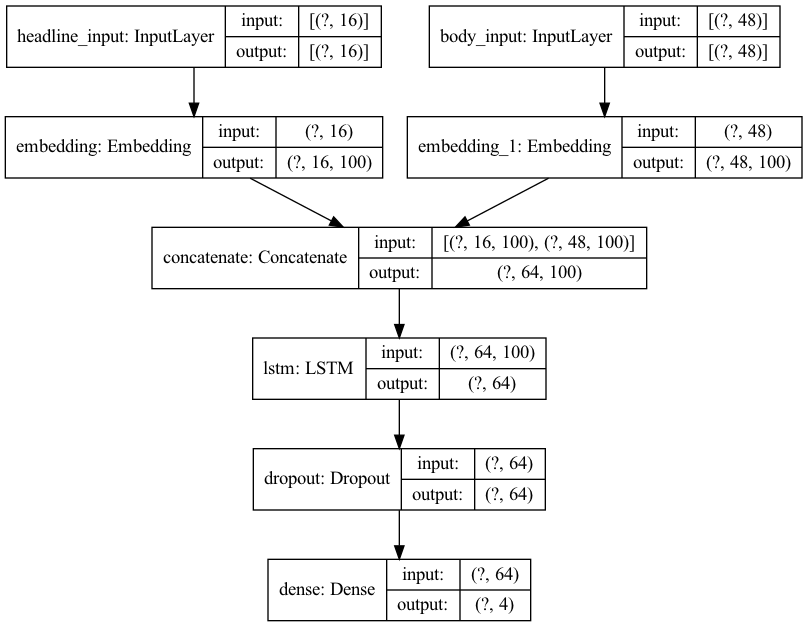

In [18]:
plot_model(lstm, to_file='model_glove_lstm.png', show_shapes=True, show_layer_names=True)

### LSTM Model Train

In [19]:
# MODELS_DIR = os.path.join("/home/abhinav/fake_news_challenge/model/glove_lstm")
filepath = os.path.join(os.getcwd(),"{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [20]:
X_train_headline.shape

(1999, 16)

In [21]:
lstm.fit([X_train_headline,X_train_body],label_train,epochs=10,shuffle=True,verbose=1,
                          validation_data=([X_test_headline,X_test_body],label_test),callbacks=[checkpoint])

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.8962 - accuracy: 0.7249
Epoch 00001: val_accuracy improved from -inf to 0.75800, saving model to /Users/ivabubalo/Documents/MSc in AI/Thesis/Code/01-0.76.hdf5
63/63 [==============================] - 7s 106ms/step - loss: 0.8962 - accuracy: 0.7249 - val_loss: 0.7590 - val_accuracy: 0.7580
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.7947 - accuracy: 0.7384
Epoch 00002: val_accuracy did not improve from 0.75800
63/63 [==============================] - 6s 89ms/step - loss: 0.7947 - accuracy: 0.7384 - val_loss: 0.7494 - val_accuracy: 0.7580
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.7686 - accuracy: 0.7384
Epoch 00003: val_accuracy did not improve from 0.75800
63/63 [==============================] - 6s 100ms/step - loss: 0.7686 - accuracy: 0.7384 - val_loss: 0.7445 - val_accuracy: 0.7580
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.7313 - accu

In [ ]:
# Generate predicted output 
#yhat = lstm.predict([label_test, X_test_headline], verbose=1)